## Виконання роботи

In [1]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl

from matplotlib import pyplot as plt
import plotly.graph_objects as go

In [ ]:
# Вхідні дані
coord_start, coord_stop = -2, 3

In [ ]:
# Плавний графік функції
long_x = np.linspace(coord_start, coord_stop, 60)
long_y = long_x.copy()

long_X, long_Y = np.meshgrid(long_x, long_y)
long_Z = long_X * np.cos(long_Y) + np.sin(long_X)

fig = go.Figure(data=[go.Surface(x=long_x, y=long_y, z=long_Z)])

fig.update_layout(title='Z = X * cos(Y) + sin(X) -- плавний',
                  width=800, height=600, margin=dict(t=50, b=0, l=0, r=0))
fig.update_layout(template='plotly_dark')  # dark mode
fig.update_scenes(
    yaxis = dict(autorange = 'reversed'),  # reverse y axis
    aspectmode='cube'  # same aspect ratio for all 3 axes
)
fig.show()

In [2]:
# Дискретні дані:
n_coords = 6
x = np.linspace(coord_start, coord_stop, n_coords)
y = x.copy()
y=np.linspace(coord_start, coord_stop, n_coords)

In [3]:
# Вихідна функція
X, Y = np.meshgrid(x, y)
Z = X * np.cos(Y) + np.sin(X)

In [4]:
# Значення функції
df = pd.DataFrame(Z)
df.columns = x
df.index = y
df.columns.name = 'x'
df.index.name = 'y'

df

x,-2.0,-1.0,0.0,1.0,2.0,3.0
y,,,,,,
-2.0,-0.077004,-0.425324,0.0,0.425324,0.077004,-1.107321
-1.0,-1.989902,-1.381773,0.0,1.381773,1.989902,1.762027
0.0,-2.909297,-1.841471,0.0,1.841471,2.909297,3.141120
1.0,-1.989902,-1.381773,0.0,1.381773,1.989902,1.762027
2.0,-0.077004,-0.425324,0.0,0.425324,0.077004,-1.107321
3.0,1.070688,0.148522,0.0,-0.148522,-1.070688,-2.828857


In [34]:
# Графік функції
fig = go.Figure(data=[go.Surface(x=x, y=y, z=Z)])

fig.update_layout(title='Z = X * cos(Y) + sin(X)',
                  width=800, height=600, margin=dict(t=50, b=0, l=0, r=0))
fig.update_layout(template='plotly_dark')  # dark mode
fig.update_scenes(
    yaxis = dict(autorange = 'reversed'),  # reverse y axis
    aspectmode='cube'  # same aspect ratio for all 3 axes
)
fig.show()

In [6]:
# Creating membership functions

min_mf, max_mf = -3, 3.2

mx = ctrl.Antecedent(np.linspace(coord_start, coord_stop, 101), "mx")  # (101-1)⋮(6-1)
my = ctrl.Antecedent(np.linspace(coord_start, coord_stop, 101), "my")
mf = ctrl.Consequent(np.linspace(min_mf, max_mf , 97), "mf")  # (97-1)⋮(9-1)

# Triangle membership functions:
mx.automf(6, names=[f'mx{i}' for i in range(6)])
my.automf(6, names=[f'my{i}' for i in range(6)])
mf.automf(9, names=[f'mf{i}' for i in range(9)])

In [7]:
# Choosing the membership function with the max. membership (for mf):
mf_n_steps = (9-1) * 2
mf_step = (max_mf - min_mf) / mf_n_steps
mf_bins = np.arange(1, mf_n_steps, 2) * mf_step + min_mf  # breakpoints (where the maximum mf changes)
# Usage: `np.digitize(arr, mf_bins)`

# Testing:
ground_truth = np.array([term.mf for term in mf.terms.values()]).argmax(axis=0)
my_approach = np.digitize(mf.universe, mf_bins)
print((ground_truth == my_approach).all())

True


In [8]:
# Show max membership functions of Z:
Z_mf = np.digitize(Z.flatten(), mf_bins).reshape(Z.shape)
print(Z_mf)

[[4 3 4 4 4 2]
 [1 2 4 6 6 6]
 [0 1 4 6 8 8]
 [1 2 4 6 6 6]
 [4 3 4 4 4 2]
 [5 4 4 4 2 0]]


In [9]:
# Plot max membership functions of Z:
fig = go.Figure(data=[go.Surface(z=Z_mf)])

fig.update_layout(title='max membership functions of Z',
                  width=800, height=600, margin=dict(t=50, b=0, l=0, r=0))
fig.update_layout(scene = dict(
    xaxis_title="mx", yaxis_title="my", zaxis_title="mf"
))
fig.update_layout(template='plotly_dark')  # dark mode
fig.update_scenes(
    yaxis = dict(autorange = 'reversed'),  # reverse y axis
    aspectmode='cube'  # same aspect ratio for all 3 axes
)
fig.show()

In [10]:
rules = []
for n_mf in range(9):
    # pairs of indice positions of Z_mf where Z_mf == n_mf:
    y_indices, x_indices = (Z_mf == n_mf).nonzero()
    if x_indices.size == 0:
        # no mf, so no rule for it
        continue
    
    # The antecedent:
    x_ind, y_ind = x_indices[0], y_indices[0]
    antecedent = mx[f'mx{x_ind}'] & my[f'my{y_ind}']
    for x_ind, y_ind in zip(x_indices[1:], y_indices[1:]):
        antecedent |= mx[f'mx{x_ind}'] & my[f'my{y_ind}']
        
    # The consequent:
    consequent = mf[f'mf{n_mf}']

    rule = ctrl.Rule(antecedent=antecedent,
                     consequent=consequent, 
                     label=f'rule mf{n_mf}')
    rules.append(rule)

In [11]:
system = ctrl.ControlSystem(rules=rules)
sim = ctrl.ControlSystemSimulation(system)

In [45]:
# new_Z = np.zeros_like(Z)
# for j in range(len(y)):
#     for i in range(len(x)):
#         sim.inputs({'mx': x[i], 'my': y[j]})
#         sim.compute()
#         new_Z[j, i] = sim.output['mf']

In [46]:
# # Графік
# fig = go.Figure(data=[go.Surface(x=x, y=y, z=new_Z)])

# fig.update_layout(title='new_Z',
#                   width=800, height=600, margin=dict(t=50, b=0, l=0, r=0))
# fig.update_layout(template='plotly_dark')  # dark mode
# fig.update_scenes(
#     yaxis = dict(autorange = 'reversed'),  # reverse y axis
#     aspectmode='cube'  # same aspect ratio for all 3 axes
# )
# fig.show()

In [47]:
new_Z = np.zeros((len(long_y), len(long_x)))
for j in range(len(long_y)):
    for i in range(len(long_x)):
        sim.inputs({'mx': long_x[i], 'my': long_y[j]})
        sim.compute()
        new_Z[j, i] = sim.output['mf']

In [48]:
# Графік
fig = go.Figure(data=[go.Surface(x=long_x, y=long_y, z=new_Z)])

fig.update_layout(title='new_Z',
                  width=800, height=600, margin=dict(t=50, b=0, l=0, r=0))
fig.update_layout(template='plotly_dark')  # dark mode
fig.update_scenes(
    yaxis = dict(autorange = 'reversed'),  # reverse y axis
    aspectmode='cube'  # same aspect ratio for all 3 axes
)
fig.show()

In [36]:
# Діагональ (assuming x == y):
diag_Z = np.diag(long_Z)
diag_new_Z = np.diag(new_Z)
errors = np.abs(diag_Z - diag_new_Z) / (np.abs(diag_Z) + 1) * 100
error = round(errors.mean(), 3)

print('Error:', error, '%')

Error: 7.28 %


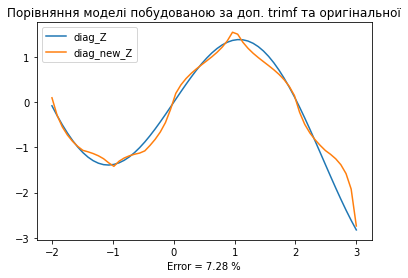

In [37]:
plt.plot(long_x, diag_Z)
plt.plot(long_x, diag_new_Z)
plt.title("Порівняння моделі побудованою за доп. trimf та оригінальної")
plt.xlabel(f"Error = {error} %")
plt.legend(['diag_Z', 'diag_new_Z'])
plt.show()

In [49]:
# # Діагональ (assuming x == y):
# diag_Z = np.diag(Z)
# diag_new_Z = np.diag(new_Z)
# errors = np.abs(diag_Z - diag_new_Z) / (np.abs(diag_Z) + 1) * 100
# error = round(errors.mean(), 3)

# print('Error:', error, '%')

In [50]:
# plt.plot(x, diag_Z)
# plt.plot(x, diag_new_Z)
# plt.title("Порівняння моделі побудованою за доп. trimf та оригінальної")
# plt.xlabel(f"Error = {error} %")
# plt.legend(['diag_Z', 'diag_new_Z'])
# plt.show()

/Users/Vladimir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



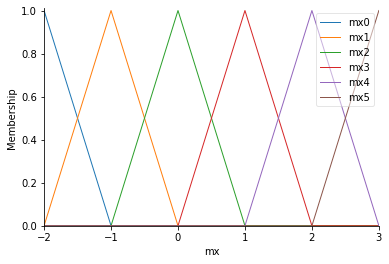

In [16]:
mx.view()

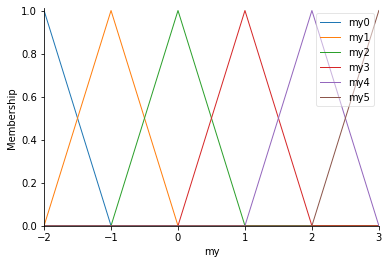

In [17]:
my.view()

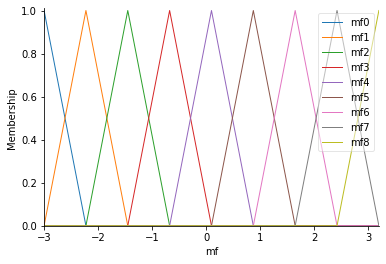

In [18]:
mf.view()

# New membership functions:

In [ ]:
# Triangle membership functions:
mx.automf(6, names=[f'mx{i}' for i in range(6)])
my.automf(6, names=[f'my{i}' for i in range(6)])
mf.automf(9, names=[f'mf{i}' for i in range(9)])

In [ ]:
mx["mx1"] = fuzz.trapmf(mx.universe, [-0.2, 0, 0.1,  0.2])
mx["mx2"] = fuzz.trapmf(mx.universe, [0, 0.2, 0.3,  0.4])
mx["mx3"] = fuzz.trapmf(mx.universe, [0.2, 0.4, 0.5,  0.6])
mx["mx4"] = fuzz.trapmf(mx.universe, [0.4, 0.6,0.7, 0.8])
mx["mx5"] = fuzz.trapmf(mx.universe, [0.6, 0.8,0.9, 1.0])
mx["mx6"] = fuzz.trapmf(mx.universe, [0.8, 1.0,1.1, 1.2])

my["my1"] = fuzz.trapmf(my.universe, [-0.2, 0, 0.1,  0.2])
my["my2"] = fuzz.trapmf(my.universe, [0, 0.2, 0.3,  0.4])
my["my3"] = fuzz.trapmf(my.universe, [0.2, 0.4, 0.5,  0.6])
my["my4"] = fuzz.trapmf(my.universe, [0.4, 0.6,0.7, 0.8])
my["my5"] = fuzz.trapmf(my.universe, [0.6, 0.8,0.9, 1.0])
my["my6"] = fuzz.trapmf(my.universe, [0.8, 1.0,1.1, 1.2])

In [ ]:
for i in range(9):
    mf[f"mf{i+1}"] = fuzz.trapmf(mf.universe, [0.9 + (0.11 * (i-1)), 0.9 + 0.11 * (i-0.2), 0.9 + 0.11 * (i+0.2), 0.9 + (0.11 * (i+1))])


In [ ]:
# fig = go.Figure(data=[go.Surface(x=x, y=y, z=Z)])

# fig.update_layout(title='Z = X * cos(Y) + sin(X)',
#                   width=800, height=600,
#                   margin=dict(l=65, r=50, b=65, t=90)
#                   )

# fig.update_scenes(   
#     # aspectmode='cube',
#     aspectratio = dict(x=1, y=1),
#     # xaxis = dict(tickmode = 'array', tickvals = x),
#     # yaxis = dict(tickmode = 'array', tickvals = y)
# )

# fig.update_scenes(
#     yaxis = dict(autorange = 'reversed')
# )

# fig.show()

In [ ]:
# #  Вхідні змінні:
# x_start, x_stop, x_step = 0, 1, 0.2
# x = np.arange(x_start, x_stop, x_step)
# y = x * np.sin(x)  # y залежить від x, але y - це буде окрема змінна для z

# # Вихідна функція:
# z = x * np.cos(y) + np.sin(x)

### 1. Побудувати нечітку модель функції двох змінних згідно з варіантом, що містить 6 функцій приналежності для вхідних змінних і не менше 9 для вихідної. 


In [ ]:
# # Plot z:
# plt.figure(figsize=(10, 6))
# plt.plot(x, z, label='z')
# plt.legend()
# plt.show()


### 2. Дослідити вплив форми функції приналежності (трикутник, трапеція, Гауса) на якість моделювання (порівняти відносні помилки моделювання). 

In [ ]:
x_mf_means = np.linspace(start, stop, 6)
y_mf_means = np.linspace(0, 1, 9)

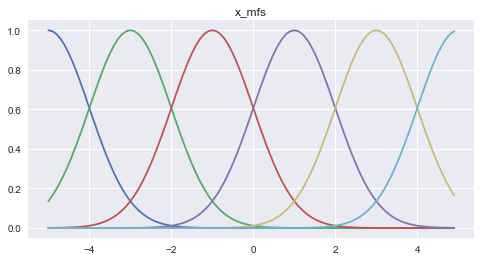

In [ ]:
plt.figure(figsize=(8, 4))

for x_mf_mean in x_mf_means:
    plt.plot(x, fuzz.gaussmf(x, x_mf_mean, 1))

plt.title('x_mfs')
plt.show()

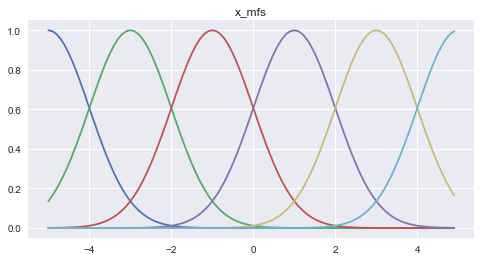

In [ ]:
plt.figure(figsize=(8, 4))

for y_mf_mean in y_mf_means:
    plt.plot(y, fuzz.gaussmf(y, y_mf_mean, 1))

plt.title('y_mfs')
plt.show()

### 3. Дослідити можливість зменшення числа правил за рахунок виключення деяких (перевірити достатність використання правил, що представляють тільки діагональ таблиці). 

### Висновок: 

У цій лабораторній роботі ми навчилися будувати нечіткі множин з використанням різних типів функцій приналежності, а також виконувати найбільш поширені логічні операції над нечіткими множинами.